ThinCurr Python Example: Compute time-domain with mode driver in a torus {#doc_tCurr_torus_td}
==========
In this example we demonstrate how to perform a time-domain simulation for a model driven by the plasma mode computed in \ref doc_tCurr_torus_mode.

**Note:** Running this example requires the [h5py](https://www.h5py.org/) and [pyvista](https://pyvista.org/) python packages, which are installable using `pip` or other standard methods.

In [1]:
import sys
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyvista
pyvista.set_jupyter_backend('static') # Comment to enable interactive PyVista plots
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load ThinCurr library

To load the ThinCurr python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` for binaries on macOS).

In [2]:
thincurr_python_path = os.getenv('OFT_ROOTPATH')
if thincurr_python_path is not None:
    sys.path.append(os.path.join(thincurr_python_path,'python'))
from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.ThinCurr import ThinCurr
from OpenFUSIONToolkit.ThinCurr.sensor import Mirnov, save_sensors
from OpenFUSIONToolkit.io import histfile

## Compute frequency response

### Setup ThinCurr model
We now create a \ref OpenFUSIONToolkit.OFT_env "OFT_env" instance for execution using four threads and a \ref OpenFUSIONToolkit.ThinCurr.ThinCurr "ThinCurr" instance that utilizes that execution environment. Once created, we setup the model from an existing HDF5 and XML mesh definition using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.setup_model "setup_model()".

We also initialize I/O for this model using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.setup_io "setup_io()" to enable output of plotting files for 3D visualization in [VisIt](https://visit-dav.github.io/visit-website/index.html), [Paraview](https://www.paraview.org/), or using [pyvista](https://pyvista.org/) below.

In [3]:
myOFT = OFT_env(nthreads=2)
tw_torus = ThinCurr(myOFT)
tw_torus.setup_model(mesh_file='thincurr_ex-torus.h5',xml_filename='oft_in.xml')
tw_torus.setup_io()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   v1_beta6
Revision id:          681e857
Parallelization Info:
  # of MPI tasks      =    1
  # of NUMA nodes     =    1
  # of OpenMP threads =    2
Fortran input file    = /var/folders/52/n5qxh27n4w19qxzqygz2btbw0000gn/T/oft_64930/oftpyin
XML input file        = none
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


Creating thin-wall model
 Orientation depth =        3122
  Loading V(t) driver coils
  Loading I(t) driver coils

  # of points    =         2394
  # of edges     =         7182
  # of cells     =         4788
  # of holes     =            2
  # of Vcoils    =            0
  # of closures  =            1
  # of Icoils    =            1

  Building holes

  Loading region resistivity:
     1  1.2570E-05


### Create sensor file
Before running the main calculations we will also define some sensors to measure the magnetic field. In ThinCurr all sensors measure the flux passing through a 3D path of points, but there are several helper classes to define common sensors (eg. \ref OpenFUSIONToolkit.ThinCurr.sensor.circular_flux_loop "Poloidal flux" and \ref OpenFUSIONToolkit.ThinCurr.sensor.Mirnov "Mirnovs"). Here we define two Mirnov sensors to measure the Z-component of the magnetic field 5 cm on either side of the torus. \ref OpenFUSIONToolkit.ThinCurr.sensor.save_sensors "save_sensors()" is then used to save the resulting sensor for later use.

After defining the sensors we use \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.compute_Msensor "compute_Msensor()" to setup the sensors and compute mutual matrices between the sensors and the model (`Msensor`) and the sensors and Icoils (`Msc`).

In [4]:
sensors = [
    Mirnov([1.45,0.0,0.0], [0.0,0.0,1.0], 'Bz_inner'),
    Mirnov([1.55,0.0,0.0], [0.0,0.0,1.0], 'Bz_outer'),
    Mirnov([1.45,0.0,0.0], [1.0,0.0,0.0], 'Br_inner'),
    Mirnov([1.55,0.0,0.0], [1.0,0.0,0.0], 'Br_outer'),
]
save_sensors(sensors)
Msensor, Msc, sensor_obj = tw_torus.compute_Msensor('floops.loc')


 Loading floop information:
   # of floops =           4
 Building element->sensor inductance matrix
 Building coil->sensor inductance matrix


### Compute self-inductance and resistivity matrices
With the model setup, we can now compute the self-inductance and resistivity matrices. A numpy version of the self-inductance matrix will be stored at \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.Lmat "tw_torus.Lmat". By default the resistivity matrix is not moved to python as it is sparse and converting to dense representation would require an increase in memory. These matrices correspond to the $\textrm{L}$ and $\textrm{R}$ matrices for the physical system

$\textrm{L} \frac{\partial I}{\partial t} + \textrm{R} I = V$

**Note:** For larger models calculating the self-inductance may take some time due to the $N^2$ interaction of the elements (see \ref doc_thincurr_ex4 for more information).

In [5]:
Mc = tw_torus.compute_Mcoil()
tw_torus.compute_Lmat()
tw_torus.compute_Rmat()

 Building coil<->element inductance matrices
     Time =  0s          
 Building coil<->coil inductance matrix
 Building element<->element self inductance matrix
     Time =  7s          
 Building resistivity matrix


## Setup plasma mode driver model
We now create a second \ref OpenFUSIONToolkit.ThinCurr.ThinCurr "ThinCurr" instance for the plasma mode utilizes the same execution environment as above. For this case we also load the plasma mode current patterns created in \ref doc_tCurr_torus_mode.

In [6]:
tw_mode = ThinCurr(myOFT)
tw_mode.setup_model(mesh_file='thincurr_mode.h5')
with h5py.File('thincurr_mode.h5', 'r+') as h5_file:
    mode_drive = np.asarray(h5_file['thincurr/driver'])


Creating thin-wall model
 Orientation depth =       12640
  Loading V(t) driver coils
  Loading I(t) driver coils

  # of points    =         6320
  # of edges     =        18960
  # of cells     =        12640
  # of holes     =            3
  # of Vcoils    =            0
  # of closures  =            2
  # of Icoils    =            0

  Building holes


## Compute coupling from plasma mode to torus model
To use this current distribution we need the inductive coupling between the mode currents and the ThinCurr model of the wall (`tw_wall`). This can be done using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.cross_eval "cross_eval()", which in this case computes the flux through each element on `tw_wall` due to the currents specified by weights `mode_drive` corresponding to the model `tw_mode`. We also compute the coupling of the plasma mode to the sensors.

In [7]:
Msensor_plasma, _, _ = tw_mode.compute_Msensor('floops.loc')
mode_driver = tw_mode.cross_eval(tw_torus,mode_drive)
sensor_mode = np.dot(mode_drive,Msensor_plasma)


 Loading floop information:
   # of floops =           4
 Building element->sensor inductance matrix
 Building coil->sensor inductance matrix
 Applying MF element<->element inductance matrix
     Time = 33s          


## Perform time-domain simulation of growing and rotating mode
With the model fully defined we can now use \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.run_td "run_td()" to perform a time-domain simulation. In this case we simulate the mode with a growth rate of 2,000 1/s and a rotation frequency of 1 kHz for four periods using a timestep of 1/50 of the rotation period (200 steps). We also specify using a direct solver for the time-advance (`direct=True`).

The driver waveform is set by defining appropriate Sin/Cos scale functions for the driver basis functions (`mode_driver`) and their derivatives, which in turn correspond to scale factors for the current and voltage. These are then used to define a voltage source for the time-domain and the sensor signal produced by these currents, which are not directly included in the simulation.

**Note:** The inductive voltage induced by a time-varying current is $V = - M dI/dt$

In [8]:
mode_freq = 1.E3
mode_growth = 2.E3
dt = (1.0/1.E3)/50.0
nsteps = 200
timebase_current = np.arange(0.0,dt*nsteps+1,dt/4.0); timebase_voltage = (timebase_current[1:]+timebase_current[:-1])/2.0
cos_current = timebase_current/mode_growth*np.cos(mode_freq*2.0*np.pi*timebase_current); cos_voltage = -np.diff(cos_current)/np.diff(timebase_current)
sin_current = timebase_current/mode_growth*np.sin(mode_freq*2.0*np.pi*timebase_current); sin_voltage = -np.diff(sin_current)/np.diff(timebase_current)
volt_full = np.zeros((nsteps+2,tw_torus.nelems+1))
sensor_signals = np.zeros((nsteps+2,sensor_mode.shape[1]+1))
for i in range(nsteps+2):
    volt_full[i,0] = dt*i
    sensor_signals[i,0] = dt*i
    if i > 0:
        volt_full[i,1:] = mode_driver[0,:]*np.interp(volt_full[i,0],timebase_voltage,cos_voltage) \
          + mode_driver[1,:]*np.interp(volt_full[i,0],timebase_voltage,sin_voltage)
        sensor_signals[i,1:] = sensor_mode[0,:]*np.interp(volt_full[i,0],timebase_current,cos_current) \
          + sensor_mode[1,:]*np.interp(volt_full[i,0],timebase_current,sin_current)
tw_torus.run_td(dt,nsteps,status_freq=10,full_volts=volt_full,sensor_obj=sensor_obj,direct=True,sensor_values=sensor_signals)


 Starting simulation
 Starting factorization
 Inverting real matrix
   Time =   0.33891700000000002     
 Timestep           10   1.99999995E-04   3.99827229E-07           1
 Timestep           20   3.99999990E-04   5.56573525E-07           1
 Timestep           30   6.00000028E-04   1.00404748E-06           1
 Timestep           40   7.99999980E-04   1.52440816E-06           1
 Timestep           50   1.00000005E-03   1.17628156E-06           1
 Timestep           60   1.20000006E-03   2.44649073E-06           1
 Timestep           70   1.39999995E-03   1.94968584E-06           1
 Timestep           80   1.59999996E-03   2.67586893E-06           1
 Timestep           90   1.79999997E-03   3.43731426E-06           1
 Timestep          100   2.00000009E-03   2.36427718E-06           1
 Timestep          110   2.19999999E-03   4.49318622E-06           1
 Timestep          120   2.40000011E-03   3.34289325E-06           1
 Timestep          130   2.60000001E-03   4.34776484E-06          

### Plot sensor evolution
We can now plot the signals from the two flux loops defined above as a function of time. During the time-domain run this information is stored in OFT's binary history file format, which can be read using the \ref OpenFUSIONToolkit.io.histfile "histfile" class. This class stores the resulting signals in a Python dict-like representation.

In the below plots the vacuum field (no eddy currents) is shown in the dashed lines and the full field is shown in the solid lines, where the external fields are suppressed by eddy currents and the internal tangential field (`Bz_inner`) is enhanced.


OFT History file: floops.hist
  Number of fields = 5
  Number of entries = 201

  Fields:
    time: Simulation time [s] (d1)
    Bz_inner: No description (d1)
    Bz_outer: No description (d1)
    Br_inner: No description (d1)
    Br_outer: No description (d1)



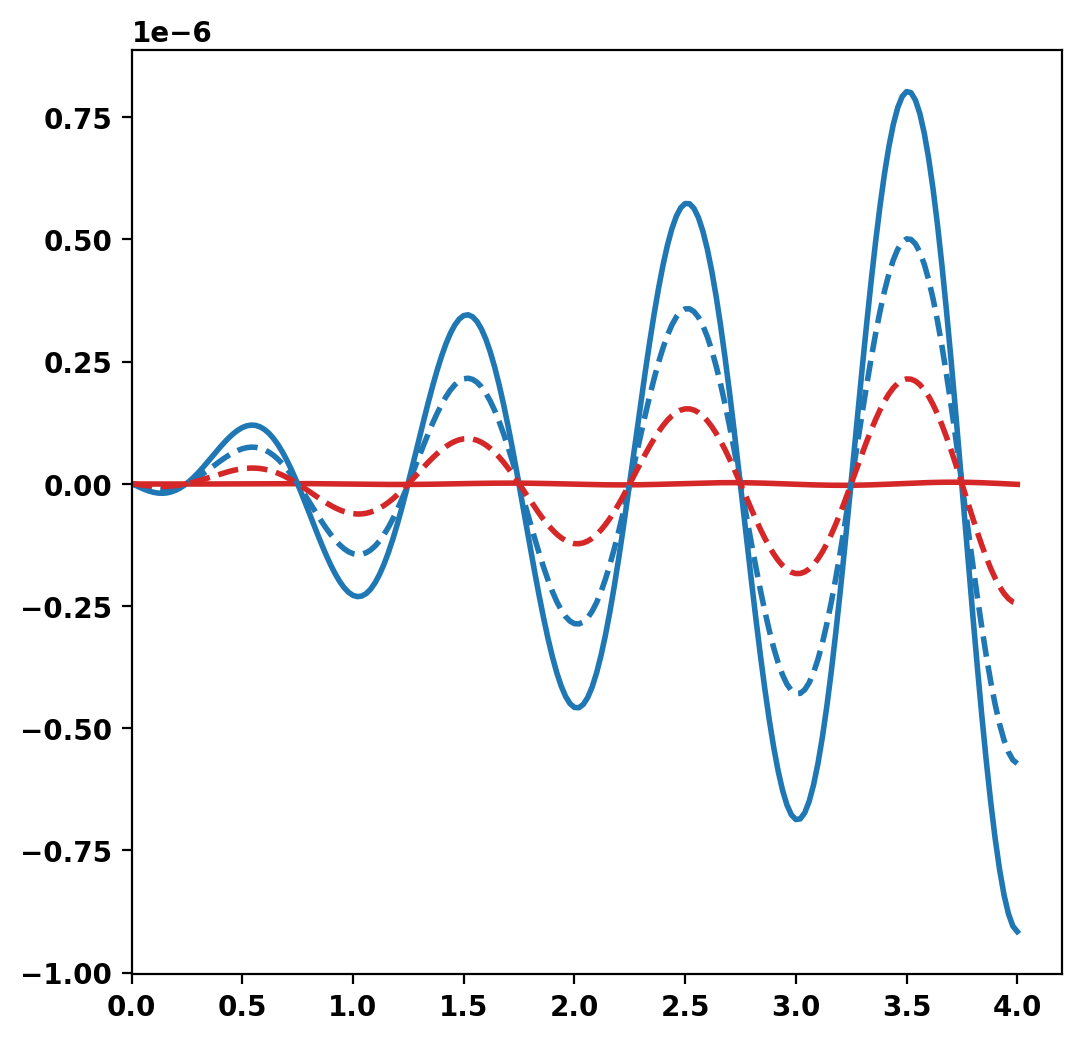

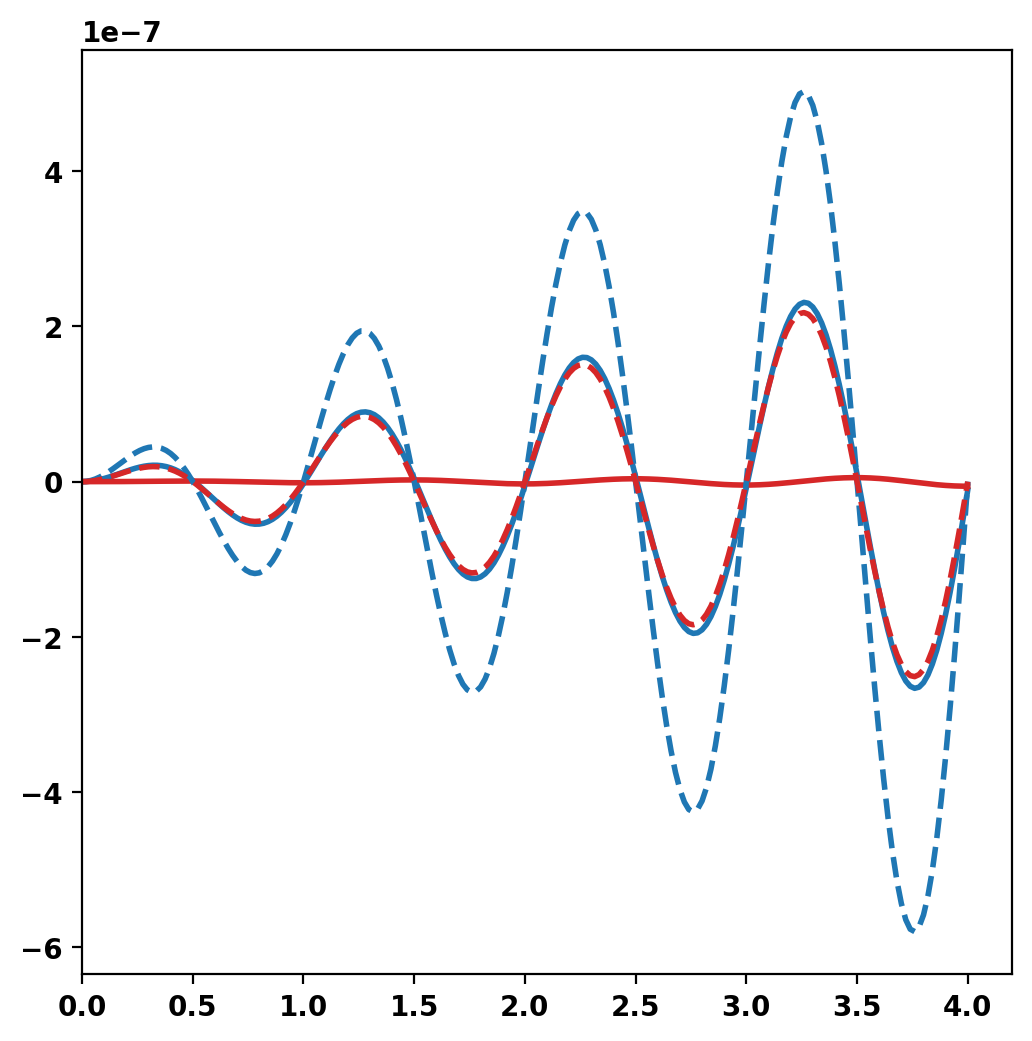

In [9]:
hist_file = histfile('floops.hist')
print(hist_file)

fig, ax = plt.subplots(1,1)
ax.plot(hist_file['time']*1.E3,hist_file['Bz_inner'],color='tab:blue')
ax.plot(hist_file['time']*1.E3,hist_file['Bz_outer'],color='tab:red')
ax.plot(hist_file['time']*1.E3,sensor_signals[:-1,1],'--',color='tab:blue')
ax.plot(hist_file['time']*1.E3,sensor_signals[:-1,2],'--',color='tab:red')
_ = ax.set_xlim(left=0.0)

fig, ax = plt.subplots(1,1)
ax.plot(hist_file['time']*1.E3,hist_file['Br_inner'],color='tab:blue')
ax.plot(hist_file['time']*1.E3,hist_file['Br_outer'],color='tab:red')
ax.plot(hist_file['time']*1.E3,sensor_signals[:-1,3],'--',color='tab:blue')
ax.plot(hist_file['time']*1.E3,sensor_signals[:-1,4],'--',color='tab:red')
_ = ax.set_xlim(left=0.0)

### Generate plot files
After completing the simulation we can generate plot files using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.plot_td "tw_torus.plot_td()". Plot files are saved at a fixed timestep interval, specified by the `nplot` argument to \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.run_td "run_td()" with a default value of 10.

Once all fields have been saved for plotting \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.build_XDMF "tw_torus.build_XDMF()" to generate the XDMF descriptor files for plotting with VisIt of Paraview. This method also returns a \ref OpenFUSIONToolkit.io.XDMF_plot_file "XDMF_plot_file" object, which can be used to read and interact with plot data in Python (see below).

In [10]:
tw_torus.plot_td(nsteps,sensor_obj=sensor_obj)
plot_data = tw_torus.build_XDMF()

 Post-processing simulation
Removing old Xdmf files
  Removed 2 files

Creating output files: oft_xdmf.XXXX.h5
  Found Group: thincurr
    Found Mesh: icoils
      # of blocks: 1
    Found Mesh: smesh
      # of blocks: 1


# Plot current fields
For demonstration purposes we now plot the the solution at the end of the driven phase using [pyvista](https://pyvista.org/). We now use the `plot_data` object to generate a 3D plot of the current at `t=2.E-3`. For more information on the basic steps in this block see \ref doc_tCurr_plate_eig

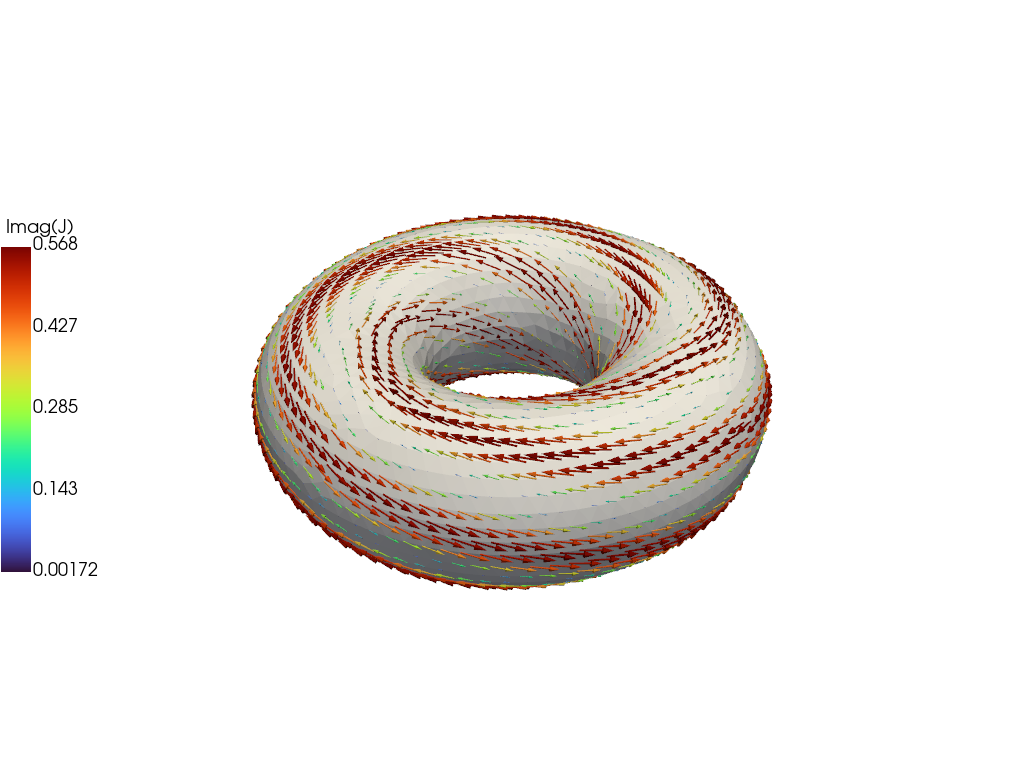

In [11]:
grid = plot_data['ThinCurr']['smesh'].get_pyvista_grid()
J = plot_data['ThinCurr']['smesh'].get_field('J_v',2.E-3)

# Plot mesh and current density using PyVista
p = pyvista.Plotter()
grid["vectors"] = J
grid.set_active_vectors("vectors")
scale = 0.2/(np.linalg.norm(J,axis=1)).max()
arrows = grid.glyph(scale="vectors", orient="vectors", factor=scale)
p.add_mesh(arrows, cmap="turbo", scalar_bar_args={'title': "Imag(J)", "vertical": True, "position_y":0.25, "position_x": 0.0})
p.add_mesh(grid, color="white", opacity=1.0, show_edges=False)
p.show()